##Management Overview
The Osceola National Forest is an incredibly heavily managed ecosystem. Fire and mechanical thinning are combined to create what the managers think looks best, in spite of there being very few ecologically minded metrics to make such an assessment. However, the ecosystems are adapted for very frequent fire, with return intervals of fewer than 3 years in some locations. The driving force behind conducting these treatments is not really to mitigate intense disturbances such as extreme wildfire events, but rather to increase the harvest potential of the forest, by creating even age, single species stands. For soem reason, Palmetto reduction is one of those goals as well.

This study aims to understand current management practices, but more specifically, aims to understand the potential role management (prescribed fire and mechanical thinning) can have on mitigating the extreme fire weathe rdriven events that are becoming more frequent across the US.

To that end, this notebooks describes the modeling framework nuts and bolts required to build the Osceola management regions, design the treatments, and investigate the impact those treatments have on the underlying fire behavior model.

### Load required libraries

In [1]:
# Load required libraries and establish data directories

# ------- Notebook config
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr
from scipy import stats
import random, ast, csv, math

# ------- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

# ------- LANDIS Utilities
from NECN_utils import *
from DFFS_FBPS_utils import *
from raster_utils import *
dataDir = 'Y:/DanK/Osceola/common/'

:0: FutureWarning: IPython widgets are experimental and may change in the future.
C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Establishing management zones ...
for the Osceola JFSP project is sort of a tricky thing. First off, there are only two distinct differences in vegetation type: pine dominated and hardwood. The hardwood areas are never going to be treated, since they're exclusively in swampy regions. However, we do want to think about treating the areas that surround the swamps, to create a sort of buffer between the less frequent but more catastrophic fires that are typical of ignitions in the swampy regions.

### Lets take a look at our existing ecoregions
These are basically our baseline management regions. The basic strategy here is to create two version of the management zones: 1) don't buffer the swamps, 2) buffer the swamps by 2 pixels. Thats basically it.

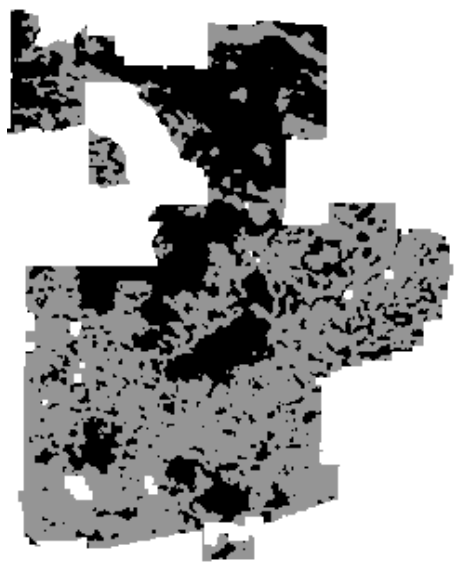

In [2]:
ecoR = importRaster(dataDir + 'Osceola_Ecoregions_150.tif')
f, (ax1) = plt.subplots(1,1, figsize = (10,10))
plotRaster(ecoR, ax = ax1)
sns.set_style('white')
sns.despine(left = True, bottom = True)

### Because the strategy is just to buffer the swamps
we can make use of a kernel type operator to query the 9 cells in a 3x3 moving window. Not too complicated. If we want to create a 2 pixel buffer, and make it so that the buffered region has a different value relative to the original swamp regions, we can break the process up into a couple steps. 1) take all swamp cells, plus their surrounding cells, and turn them into a buffer value. 2) take all buffer cells, plus their surrounding cells, and turn them into a buffer value, 3) use the original layer to difference or multiply the new buffer layer, and build the swamp layers back into the buffered layer.

In [3]:
# Read in template rasters
ecoR        = importRaster(dataDir + 'Osceola_Ecoregions_150.tif')
swmpBuffer1 = importRaster(dataDir + 'Osceola_Ecoregions_150.tif')
swmpBuffer2 = importRaster(dataDir + 'Osceola_Ecoregions_150.tif')

height, width = ecoR.shape

# Run the buffering twice. Note that here we are activating the 
# kernel operator if we detect a swamp value (2)
for row in range(0,height):
    for col in range(0,width):
        if 2 in cell_neighbors(swmpBuffer1, row, col, 1):
            swmpBuffer1[row,col] = 3

# This iteration, note that we are activating the kernel operator if we
# detect a buffer value (3), because there should no longer be any swamp
# values (2s)
for row in range(0,height):
    for col in range(0,width):
        if 3 in cell_neighbors(swmpBuffer1, row, col, 1):
            swmpBuffer2[row,col] = 3 

# Create a new version of the management layer
# This is nice and easy, 0 and 1 stay the same. 
# swamp becomes 6, buffer becomes 3.
mgmtLayers = ecoR * swmpBuffer2

# Write the IC raster to file as well
saveAsGeoTiff(dataDir + 'Osceola_Ecoregions_150.tif', mgmtLayers,
              dataDir + 'Osceola_MGMT.tif', 26917)

### Visualuize the result
In this haneous display, red represents swamps, light blue is the pine area, and bright green is the buffered region.

array([ 0.,  1.,  3.,  6.])

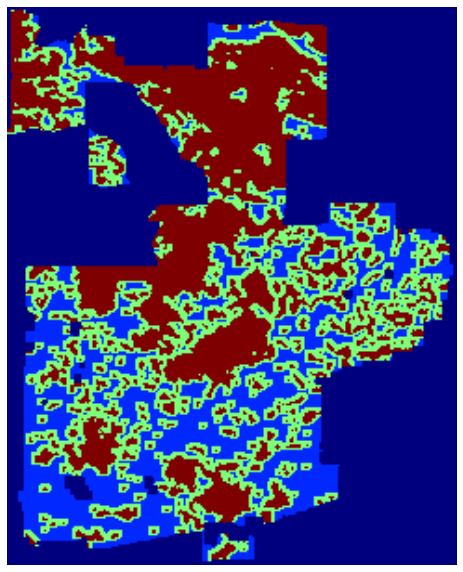

In [4]:
f, (ax1) = plt.subplots(1,1, figsize = (10,10))
plotRaster(mgmtLayers, ax = ax1, cmap = 'jet')
np.unique(mgmtLayers)

### Want to create a quick report of areas in each unit
so that we can use those values to help in assigning treatments, and calculate the area thinned / burned etc per year/

In [6]:
OSMGMT = pd.DataFrame(dict(MGMT = mgmtLayers.ravel()))
OSMGMT['cells'] = OSMGMT.index
OSMGMTCount = OSMGMT.groupby(['MGMT']).count().reset_index()
OSMGMTCount['area'] = OSMGMTCount.cells * 2.25 
OSMGMTCount

,MGMT,cells,area
0,0.0,32062,72139.50
1,1.0,10737,24158.25
2,3.0,13588,30573.00
3,6.0,16455,37023.75


### Finally we need to create a stand map
this way LANDIS knows how to treat the application of thinning and rxFire treatments within the management zones we created above. This is a pretty simple process, and the old function from the Dinkey Creek project works just fine.

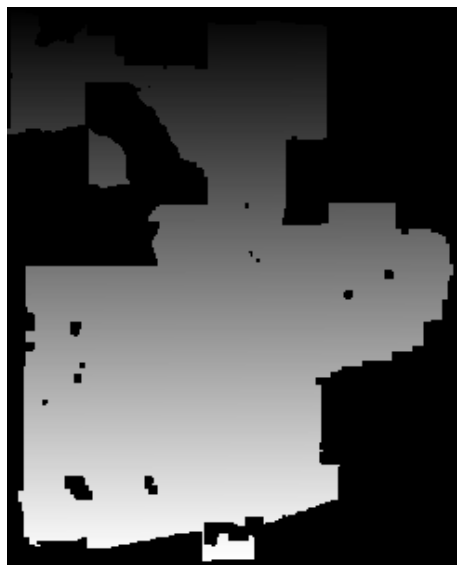

In [7]:
genStandMap(dataDir, 'Osceola_Ecoregions_150.tif', 'OsceolaStands.tif')
osceolaStands = importRaster(dataDir + 'OsceolaStands.tif')
f, (ax1) = plt.subplots(1,1, figsize = (10,10))
plotRaster(osceolaStands, ax = ax1, cmap = 'gray')

## Fuel types description
We need to take a look at the ROS of the fuel types we described in the DFFS for LANDIS. This becomes important when we want to look at the impact of altering fuel types on fire behavior (primarily rate of spread). To start, we will produce the ROS surfaces for each fuel type currently in use by the DFFS. I've also included fuel types 91 and 92, temporary proxies for waht happens to the pine fuel types when they are exposed to mechanical thinning or prescribed burning. These numbers need to be tweaked based on the difference in ROS that results from the changes. Note here however that across the board, the CBH is increased to that of the old stands. This is intentional and reasonable, and will make sure that ultimately the ROS governs changes to CFB (crown fraction burned), and not CBH. 

In [8]:
osceolaFuels = pd.read_csv(dataDir + 'OsceolaFuels.csv')
osceolaFuels

,LANDIS_Code,Base Type,FBP_Code,IgnProb,a,b,c,q,BUI,maxBE,CBH,FuelName
0,1,Conifer,C5,0.010,50,0.0800,3.5,0.80,56,1.22,0,Pine Young
1,2,Conifer,C5,0.010,33,0.0800,3.5,0.89,56,1.22,2,Pine Mid
2,3,Conifer,C5,0.010,30,0.0800,3.5,0.89,56,1.22,5,Pine Old
3,4,Deciduous,D1,0.005,180,0.0232,6.0,1.00,50,2.00,0,Swamp Young
4,5,Deciduous,D1,0.005,180,0.0232,6.0,1.00,90,2.00,2,Swamp Old
5,91,Conifer,C5,0.001,30,0.0200,3.2,0.85,25,1.00,5,pineThin
6,92,Conifer,C5,0.001,30,0.0300,3.3,0.87,30,1.10,5,PineRxFire


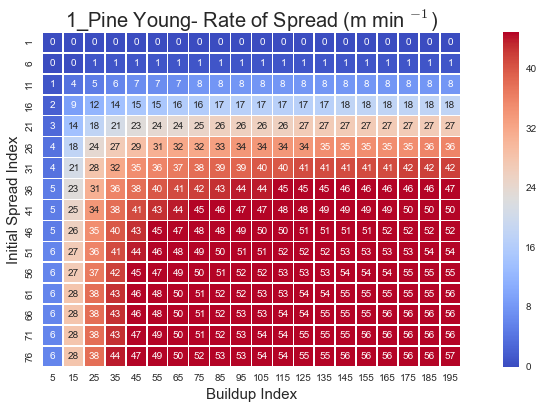

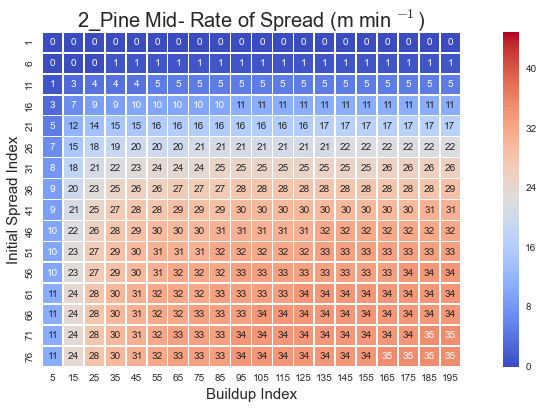

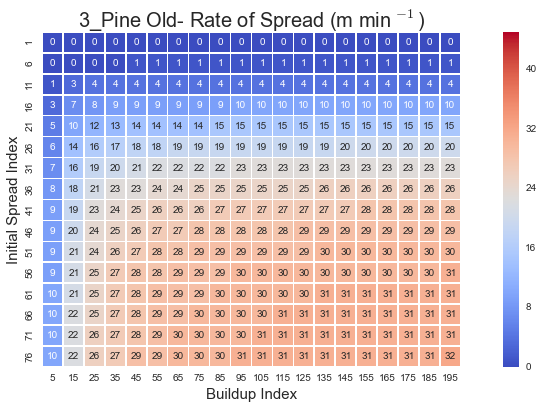

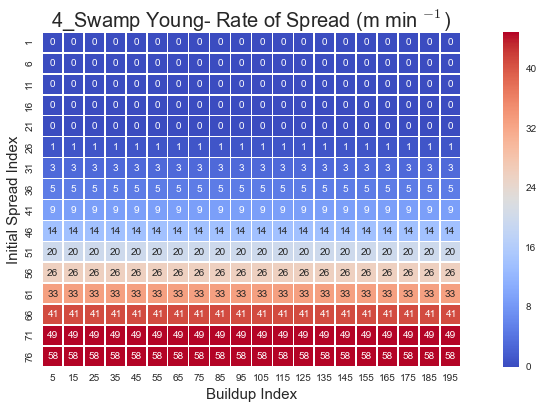

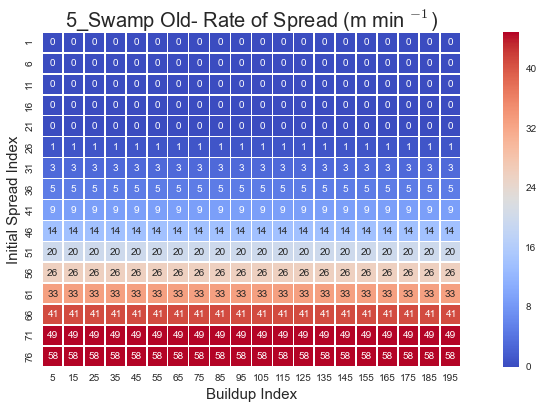

In [51]:
# Generate the arrays for ISI and BUI, bounded by the limits seen in the FBP
ISI_L = np.arange(1.,80.,5.)
BUI_L = np.arange(5.,205.,10.)
for fuelType in [1,2,3,4,5]:
    fuelName = osceolaFuels[osceolaFuels.LANDIS_Code == fuelType].FuelName.ravel()[0]
    ROS_Surface = fuelsROS(osceolaFuels, fuelType, ISI_L, BUI_L)
    f, (ax) = plt.subplots(1,1, figsize =(15,6))
    sns.heatmap(ROS_Surface, square=True, linewidths=0.2, 
                annot=True, cmap = "coolwarm", vmin = 0, vmax = 45)
    ax.set_xlabel('Buildup Index', fontsize = 15)
    ax.set_ylabel('Initial Spread Index', fontsize = 15)
    ax.set_title(str(fuelType) + '_' + fuelName + '- Rate of Spread (m min $^{-1}$)', 
                 fontsize = 20)

### Treatment differences
Now if we take a look at fuel types 91 and 92, thinning and rxFire respectively, on the ROS of each fuel type, we can infer something about how the treatment will affect fire behavior and under what conditions. First here are the differences in ROS for the thinning treatment on each pine class

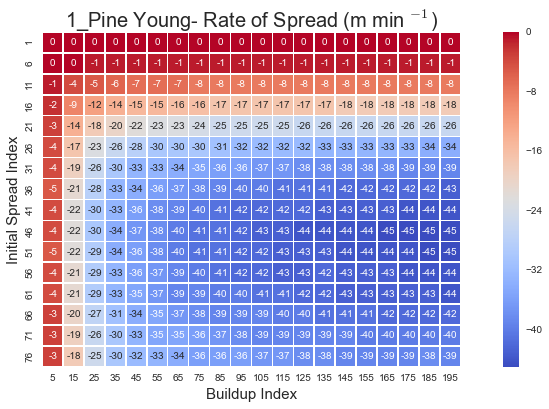

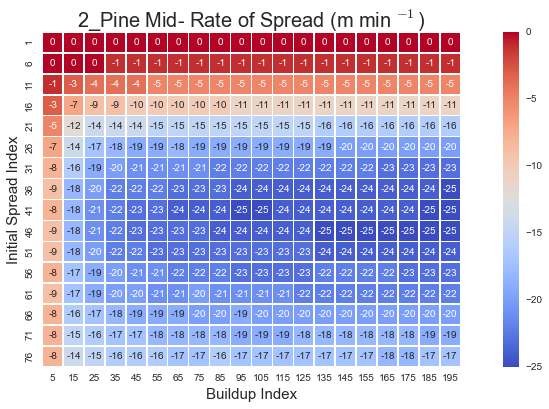

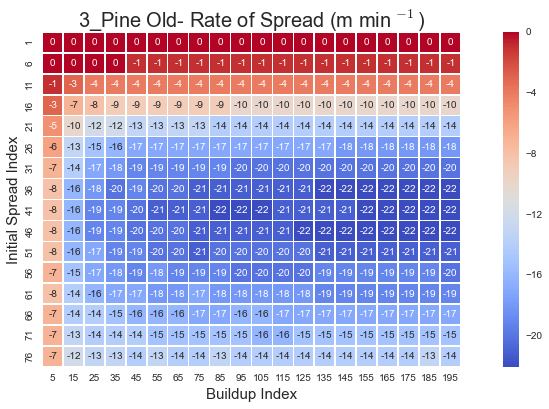

In [52]:
for fuelType in [1,2,3]:
    fuelName = osceolaFuels[osceolaFuels.LANDIS_Code == fuelType].FuelName.ravel()[0]
    ROS_Surface = fuelsROS(osceolaFuels, fuelType, ISI_L, BUI_L)
    ROS_diff    = fuelsROS(osceolaFuels, 91, ISI_L, BUI_L) - ROS_Surface
    f, (ax) = plt.subplots(1,1, figsize =(15,6))
    sns.heatmap(ROS_diff, square=True, linewidths=0.2, 
                annot=True, cmap = "coolwarm",)
    ax.set_xlabel('Buildup Index', fontsize = 15)
    ax.set_ylabel('Initial Spread Index', fontsize = 15)
    ax.set_title(str(fuelType) + '_' + fuelName + '- Rate of Spread (m min $^{-1}$)', 
                 fontsize = 20)

#### Now the affect of rxFire on each pine class

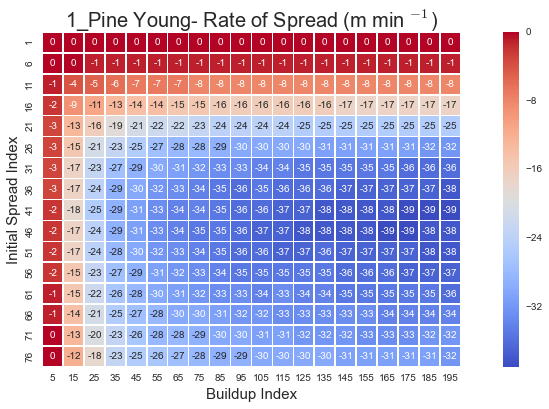

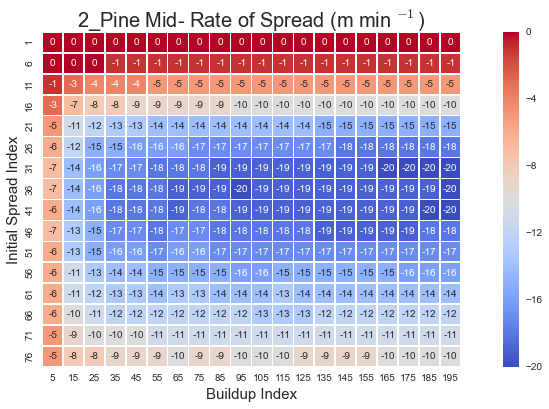

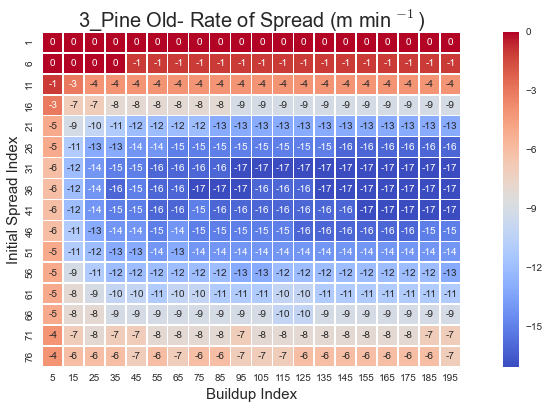

In [53]:
for fuelType in [1,2,3]:
    fuelName = osceolaFuels[osceolaFuels.LANDIS_Code == fuelType].FuelName.ravel()[0]
    ROS_Surface = fuelsROS(osceolaFuels, fuelType, ISI_L, BUI_L)
    ROS_diff    = fuelsROS(osceolaFuels, 92, ISI_L, BUI_L) - ROS_Surface
    f, (ax) = plt.subplots(1,1, figsize =(15,6))
    sns.heatmap(ROS_diff, square=True, linewidths=0.2, 
                annot=True, cmap = "coolwarm",)
    ax.set_xlabel('Buildup Index', fontsize = 15)
    ax.set_ylabel('Initial Spread Index', fontsize = 15)
    ax.set_title(str(fuelType) + '_' + fuelName + '- Rate of Spread (m min $^{-1}$)', 
                 fontsize = 20)